**** GS SOLVE ****


C:\Users\John\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Converged after 17500 iterations
Operation count: 11312000
GS took : 5.53125 secs
**** MULTIGRID SOLVE ****


C:\Users\John\anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Converged after 93 iterations
This is 93 solution iterations on the fine mesh
Operation count: 1636800
MG took : 0.890625 secs
Operation count ratio (GS/MG): 6.91105
MultiGrid was 6.21053 times faster than Gauss-Seidel !!!


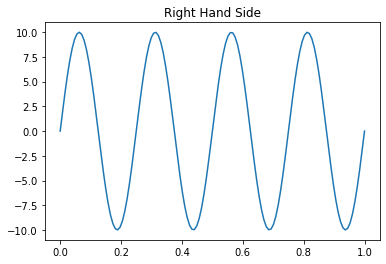

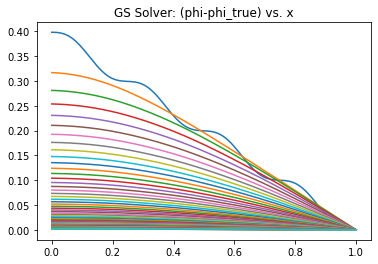

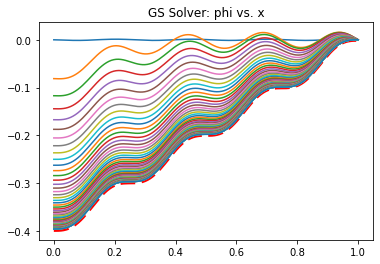

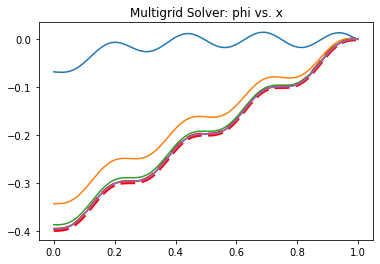

In [4]:
# -*- coding: utf-8 -*-
"""
Example 1D Multigrid solver
Written by Lubos Brieda for 
https://www.particleincell.com/2018/multigrid-solver/

Fri Mar  9 21:47:15 2018

Sat Aug 14 2021, Updated by John Coady to use V-cycle levels
"""

import numpy as np
import pylab as pl
import time

#standard GS+SOR solver
def GSsolve(phi,b):
    print("**** GS SOLVE ****")

    #plot for solution vector
    fig_sol = pl.figure()
    #plot analytical solution
    pl.plot(x,phi_true,LineWidth=4,color='red',LineStyle="dashed")
    pl.title('GS Solver: phi vs. x')
    
    #plot for error
    fig_err = pl.figure()
    pl.title('GS Solver: (phi-phi_true) vs. x')
     
    R_freq = 100 #how often should residue be computed
    w = 1.4 #SOR acceleration factor
    
    for it in range(100001):
        phi[0] = phi[1] #neumann BC on x=0
        for i in range (1,ni-1):    #Dirichlet BC at last node so skipping
            g = 0.5*(phi[i-1] + phi[i+1] - dx*dx*b[i])            
            phi[i] = phi[i] + w*(g-phi[i])
        
        #compute residue to check for convergence
        if (it%R_freq==0):    
            r_i = phi[1]-phi[0]
            r_sum = r_i*r_i
            for i in range (1, ni-1):
                r_i = (phi[i-1]-2*phi[i]+phi[i+1])/(dx*dx) - b[i]
                r_sum += r_i*r_i
        
            norm = np.sqrt(r_sum)/ni
            if (norm<1e-4): 
                print("Converged after %d iterations"%it)
                op_count = it*ni*5 + (it/R_freq)*5*ni
                print("Operation count: %d"%op_count)
                pl.figure(fig_sol.number)
                pl.plot(x,phi)
                return op_count
                break
    
        if (it % 250 ==0):
            pl.figure(fig_sol.number)
            pl.plot(x,phi)
            pl.figure(fig_err.number)
            pl.plot(x,phi-phi_true)
            #print("it: %d, norm: %g"%(it, norm))
    return -1

#multigrid solver
def MGsolve(phi,b):
    global eps_h, eps_2h, eps_4h, eps_8h, eps_16h, R_h, R_2h, R_4h, R_8h, R_16h
    print("**** MULTIGRID SOLVE ****")
    ni_h = len(phi)
    ni_2h = ni_h>>1    #divide by 2
    dx_2h = 2*dx
    ni_4h = ni_2h>>1    #divide by 2
    dx_4h = 2*dx_2h
        
    R_h = np.zeros(ni_h)
    R_2h = np.zeros(ni_2h)
    R_4h = np.zeros(ni_4h)
    eps_4h = np.zeros(ni_4h+1)
    eps_2h = np.zeros(ni_2h+1)
    eps_h = np.zeros(ni_h)
 
    pl.figure()
    #plot analytical solution
    pl.plot(x,phi_true,LineWidth=4,color='red',LineStyle="dashed")
    pl.title('Multigrid Solver: phi vs. x')
   
    for it in range(10001):
        
        #number of steps to iterate at the finest level
        inner_its = 1

        #number of steps to iterate at the coarse level        
        inner2h_its = 50
        w = 1.4
        
        #1) perform one or more iterations on fine mesh
        for n in range(inner_its):
            phi[0] = phi[1]            
            for i in range (1,ni-1):
                g = 0.5*(phi[i-1] + phi[i+1] - dx*dx*b[i])
                phi[i] = phi[i] + w*(g-phi[i])
                            
        #2) compute residue on the fine mesh, R = A*phi - b
        for i in range(1,ni-1):
            R_h[i] = (phi[i-1]-2*phi[i]+phi[i+1])/(dx*dx) - b[i]
        R_h[0] = (phi[0] - phi[1])/dx    #neumann boundary
        R_h[-1] = phi[-1] - 0   #dirichlet boundary
                    
        #2b) check for termination
        r_sum = 0
        for i in range(ni):
            r_sum += R_h[i]*R_h[i]
        norm = np.sqrt(r_sum)/ni_h
        if (norm<1e-4): 
            print("Converged after %d iterations"%it)
            print("This is %d solution iterations on the fine mesh"%(it*inner_its))
            op_count_single = (inner_its*ni_h*5 + ni_h*5 + (ni_h>>1) + 
                               inner2h_its*(ni_h>>1)*5 + ni_h + ni_h)
            print("Operation count: %d"%(op_count_single*it))
            pl.plot(x,phi)
            return op_count_single*it
            break
        
        #3) restrict residue to the 2h mesh
        for i in range(2,ni_h-1,2):
            R_2h[i>>1] = 0.25*(R_h[i-1] + 2*R_h[i] + R_h[i+1])            
        R_2h[0] = R_h[0]
            
            
       #4b) perform few iteration of the correction vector on the 2h mesh
        eps_2h[:] = 0
        for n in range(inner2h_its):
            eps_2h[0] = eps_2h[1] + dx_2h*R_2h[0]
            for i in range(1,ni_2h-1):
                g = 0.5*(eps_2h[i-1] + eps_2h[i+1] - dx_2h*dx_2h*R_2h[i])
                eps_2h[i] = eps_2h[i] + w*(g-eps_2h[i])
            
        #5) interpolate eps to h mesh
        for i in range(1,ni_h-1):
            if (i%2==0):    #even nodes, overlapping coarse mesh
                eps_h[i] = eps_2h[i>>1]
            else:
                eps_h[i] = 0.5*(eps_2h[i>>1]+eps_2h[(i>>1)+1])
            eps_h[0] = eps_2h[0]
        
        #6) update solution on the fine mesh
        for i in range(0,ni_h-1):
            phi[i] = phi[i] - eps_h[i]
              
        if (it % int(25/inner_its) == 0):
            pl.plot(x,phi)
#            print("it: %d, norm: %g"%(it, norm))
            
    return -1

ni = 128

#domain length and mesh spacing
L = 1
dx = L/(ni-1)

x = np.arange(ni)*dx

phi = np.ones(ni)*0
phi[0] = 0
phi[ni-1] = 0
phi_bk = np.zeros_like(phi)
phi_bk[:] = phi[:]


#set RHS
A = 10
k = 4
b = A*np.sin(k*2*np.pi*x/L) 

#analytical solution
C1 = A/(k*2*np.pi/L)
C2 = - C1*L
phi_true = (-A*np.sin(k*2*np.pi*x/L)*(1/(k*2*np.pi/L))**2 + C1*x + C2)

pl.figure(1)
pl.title('Right Hand Side')
pl.plot(x,b)

t = time.process_time()
#do some stuff
op_gs = GSsolve(phi,b)
elapsed_time_GS = time.process_time() - t
print("GS took : %g secs"%(elapsed_time_GS))


t = time.process_time()
#reset solution
phi = phi_bk
op_mg = MGsolve(phi,b)

elapsed_time_MG = time.process_time() - t
print("MG took : %g secs"%(elapsed_time_MG))


print("Operation count ratio (GS/MG): %g"%(op_gs/op_mg))

print("MultiGrid was %g times faster than Gauss-Seidel !!!"%(elapsed_time_GS/elapsed_time_MG))
